In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
import bounded_alphas, costs, model, weighted_costs, weighted_bounded_alphas

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [10]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("10-lags-14-weeks-chiangmai.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [5]:
%%time
# all_26 = alphas.get_alphas(26,all_dengues_train)
# weighted_cm_26 = weighted_bounded_alphas.get_alphas(26,cm_dengues_train)
cm_13 = bounded_alphas.get_alphas(13,cm_dengues_train)
# cm_52 = bounded_alphas.get_alphas(52,cm_dengues_train)
# cm_78 = alphas.get_alphas(78,cm_dengues_train)
# cr_26 = alphas.get_alphas(26,cr_dengues_train)

CPU times: user 21min 7s, sys: 11.3 s, total: 21min 18s
Wall time: 22min


In [7]:
# total = []
# for i in cm_26.x[1:-2]:
#     if i > 0:
#         total.append(i)

# np.mean(total)
# print cm_26.x[:-1].max()

In [23]:
def plot_prediction(LAG, real, ws, province, nweeks_to_predict=[1,2,4,8,16]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, first_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction)
        for i in range(weeks_ahead):
            week_to_predict = first_week_to_predict + i
            cur_prediction = model.guess(ws, week_to_predict, prev_cases)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,12
        predictions = []
        for start_week in range(len(real)-(LAG-1)):
            first_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:first_week_to_predict]
            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                first_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
#     return all_predictions

    ## plot all predictions
    plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions)

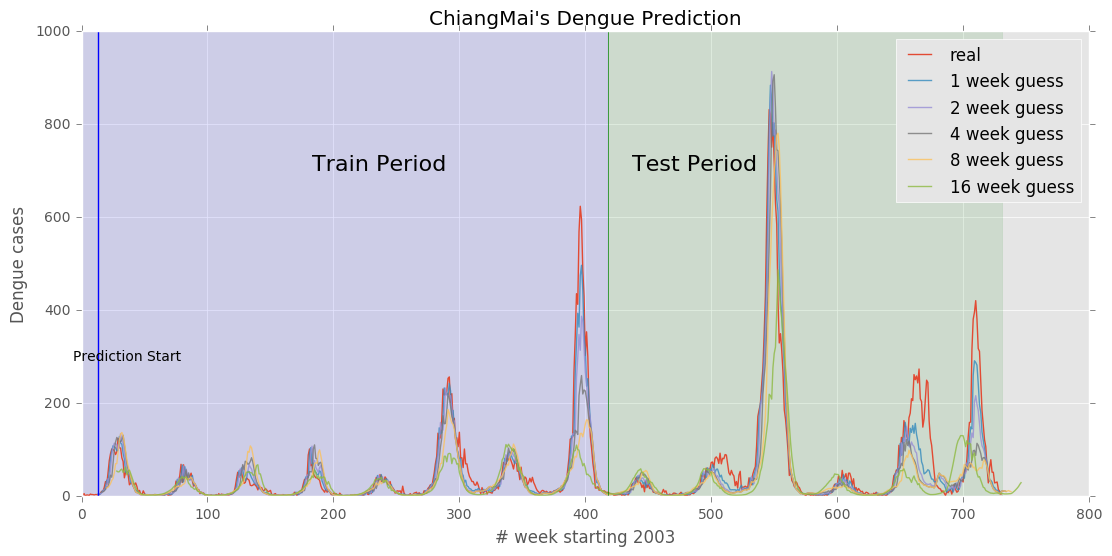

In [29]:
# plot_prediction(26,cm_dengues_df.cases,cm_26.x,"ChiangMai")
plot_prediction(13,cm_dengues_df.cases,cm_13.x,"ChiangMai")

In [30]:
cm_13.x

array([  8.07630496e-01,  -2.72547532e-08,  -1.59312151e-08,
        -5.53705215e-07,   1.41076905e-07,   3.93646017e-01,
         1.44595971e-01,   3.16775762e-08,  -3.00952739e-07,
        -6.72034318e-08,  -4.01857693e-08,  -3.65645717e-08,
        -1.89629506e-07,   6.60016649e-01,   6.01364135e-01,
         9.76688073e+00])